In [ ]:
import pandas as pd

# Đọc dữ liệu
df = pd.read_csv(r"C:\Users\nguye\CODE\TimeSeries\BTL\Data\2019-Oct.csv", parse_dates=["event_time"])
df = df.sort_values(["user_id", "event_time"])


In [2]:
df["week"] = df["event_time"].dt.to_period("W").apply(lambda r: r.start_time)


C:\Users\nguye\AppData\Local\Temp\ipykernel_27856\200525037.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["event_time"].dt.to_period("W").apply(lambda r: r.start_time)


In [3]:
# Lấy user mỗi tuần
users_by_week = df.groupby("week")["user_id"].unique().to_dict()

# Gắn nhãn churn theo tuần
churn_labels = {}

weeks = sorted(users_by_week.keys())

for i in range(len(weeks) - 1):
    current_week = weeks[i]
    next_week = weeks[i + 1]
    
    current_users = set(users_by_week[current_week])
    next_users = set(users_by_week[next_week])
    
    for user in current_users:
        churn_labels[(user, current_week)] = 0 if user in next_users else 1


In [4]:
# Gán nhãn churn vào từng dòng
def assign_churn(row):
    return churn_labels.get((row["user_id"], row["week"]), None)

df["churn"] = df.apply(assign_churn, axis=1)
df = df[df["churn"].notnull()]  # Loại bỏ tuần cuối không có nhãn

# Mã hóa event_type (view, cart, purchase, remove)
event_mapping = {'view': 0, 'cart': 1, 'remove_from_cart': 2, 'purchase': 3}
df["event_code"] = df["event_type"].map(event_mapping)


In [5]:
from collections import defaultdict

user_sequences = defaultdict(list)
user_labels = {}

# Gom các event_code theo user + week
for (user_id, week), group in df.groupby(["user_id", "week"]):
    sequence = group.sort_values("event_time")["event_code"].tolist()
    label = group["churn"].iloc[0]
    
    user_sequences[(user_id, week)] = sequence
    user_labels[(user_id, week)] = label


In [6]:
import numpy as np

# Padding hoặc cắt chuỗi dài/ngắn về độ dài cố định (VD: maxlen=20)
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = []
y = []

for key, sequence in user_sequences.items():
    label = user_labels[key]
    X.append(sequence)
    y.append(label)

X_padded = pad_sequences(X, maxlen=20, padding='post', truncating='post')
y = np.array(y)


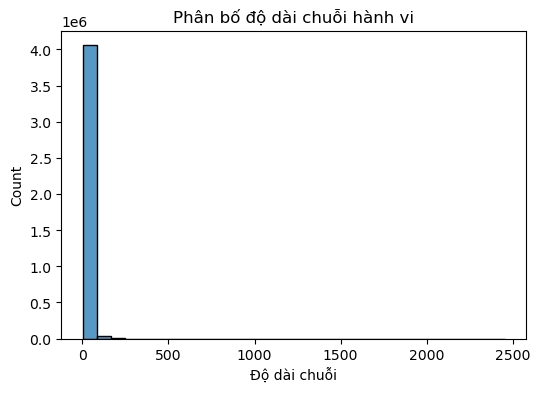

In [10]:
# Trực quan hóa độ dài chuỗi
import matplotlib.pyplot as plt
import seaborn as sns
lengths = [len(seq) for seq in X]
plt.figure(figsize=(6, 4))
sns.histplot(lengths, bins=30)
plt.title("Phân bố độ dài chuỗi hành vi")
plt.xlabel("Độ dài chuỗi")
plt.show()

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=4, output_dim=8, input_length=20),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_padded, y, batch_size=64, epochs=10, validation_split=0.2)


Epoch 1/10
51191/51191 ━━━━━━━━━━━━━━━━━━━━ 345s 7ms/step - accuracy: 0.6523 - loss: 0.6445 - val_accuracy: 0.8362 - val_loss: 0.5189
Epoch 2/10
51191/51191 ━━━━━━━━━━━━━━━━━━━━ 322s 6ms/step - accuracy: 0.6532 - loss: 0.6435 - val_accuracy: 0.8360 - val_loss: 0.5231
Epoch 3/10
51191/51191 ━━━━━━━━━━━━━━━━━━━━ 314s 6ms/step - accuracy: 0.6530 - loss: 0.6437 - val_accuracy: 0.8376 - val_loss: 0.5190
Epoch 4/10
51191/51191 ━━━━━━━━━━━━━━━━━━━━ 354s 7ms/step - accuracy: 0.6526 - loss: 0.6439 - val_accuracy: 0.8363 - val_loss: 0.5263
Epoch 5/10
51191/51191 ━━━━━━━━━━━━━━━━━━━━ 322s 6ms/step - accuracy: 0.6528 - loss: 0.6439 - val_accuracy: 0.8361 - val_loss: 0.5224
Epoch 6/10
51191/51191 ━━━━━━━━━━━━━━━━━━━━ 333s 7ms/step - accuracy: 0.6529 - loss: 0.6437 - val_accuracy: 0.8368 - val_loss: 0.5254
Epoch 7/10
51191/51191 ━━━━━━━━━━━━━━━━━━━━ 344s 7ms/step - accuracy: 0.6529 - loss: 0.6438 - val_accuracy: 0.8359 - val_loss: 0.5228
Epoch 8/10
51191/51191 ━━━━━━━━━━━━━━━━━━━━ 314s 6ms/step - ac

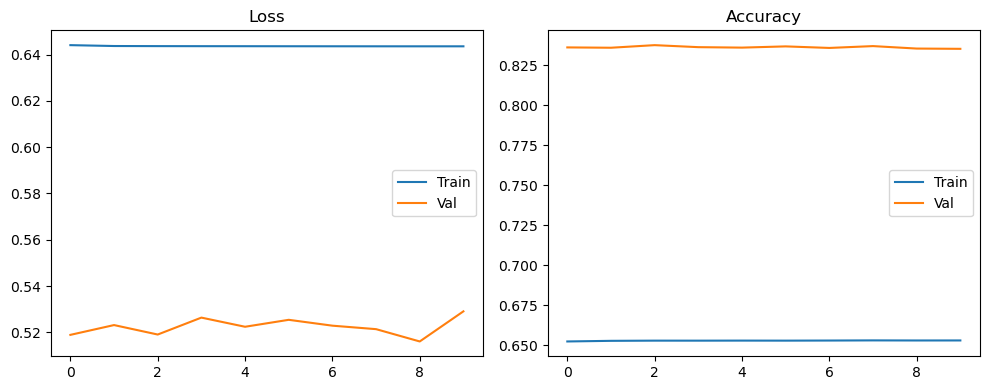

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()